In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities

from qiskit.extensions import HamiltonianGate

## Initialization

In [2]:
P = 10000
notes = [
    (50, 1),
    (54, 1),
    (57, 1),
    (57, 2),
    (69, 1),
    (69, 1),
    (P, 1),
    (66, 1),
    (66, 1),
    (P, 1),
    (50, 1),
    (50, 1),
    (54, 1),
    (57, 1),
    (57, 2),
    (69, 1),
    (69, 1),
    (P, 1),
    (67, 1),
    (67, 1),
    (P, 1),
    (49, 1),
    (49, 1),
    (52, 1),
    (59, 1),
    (59, 2),
    (71, 1),
    (71, 1),
    (P, 1),
    (67, 1),
    (67, 1),
    (P, 1)
]
arr = np.array(notes)

minval = min(arr[arr > 10])
maxval = max(arr[arr < P]) + 1
arr[arr==P] = maxval

N = 4
notes = [((a - minval)/maxval, b/N) for [a, b] in arr]




In [3]:
n_qubits = 4
SHOTS = 10000
timeseries = notes * 2

H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=160)
T = 10
UT = HamiltonianGate(H, T)

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
models = np.array([
    Ridge(alpha=alph, max_iter=int(1e8)) for alph in np.linspace(0, 1e2, 20)
] 

, dtype=object)

Simulating: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


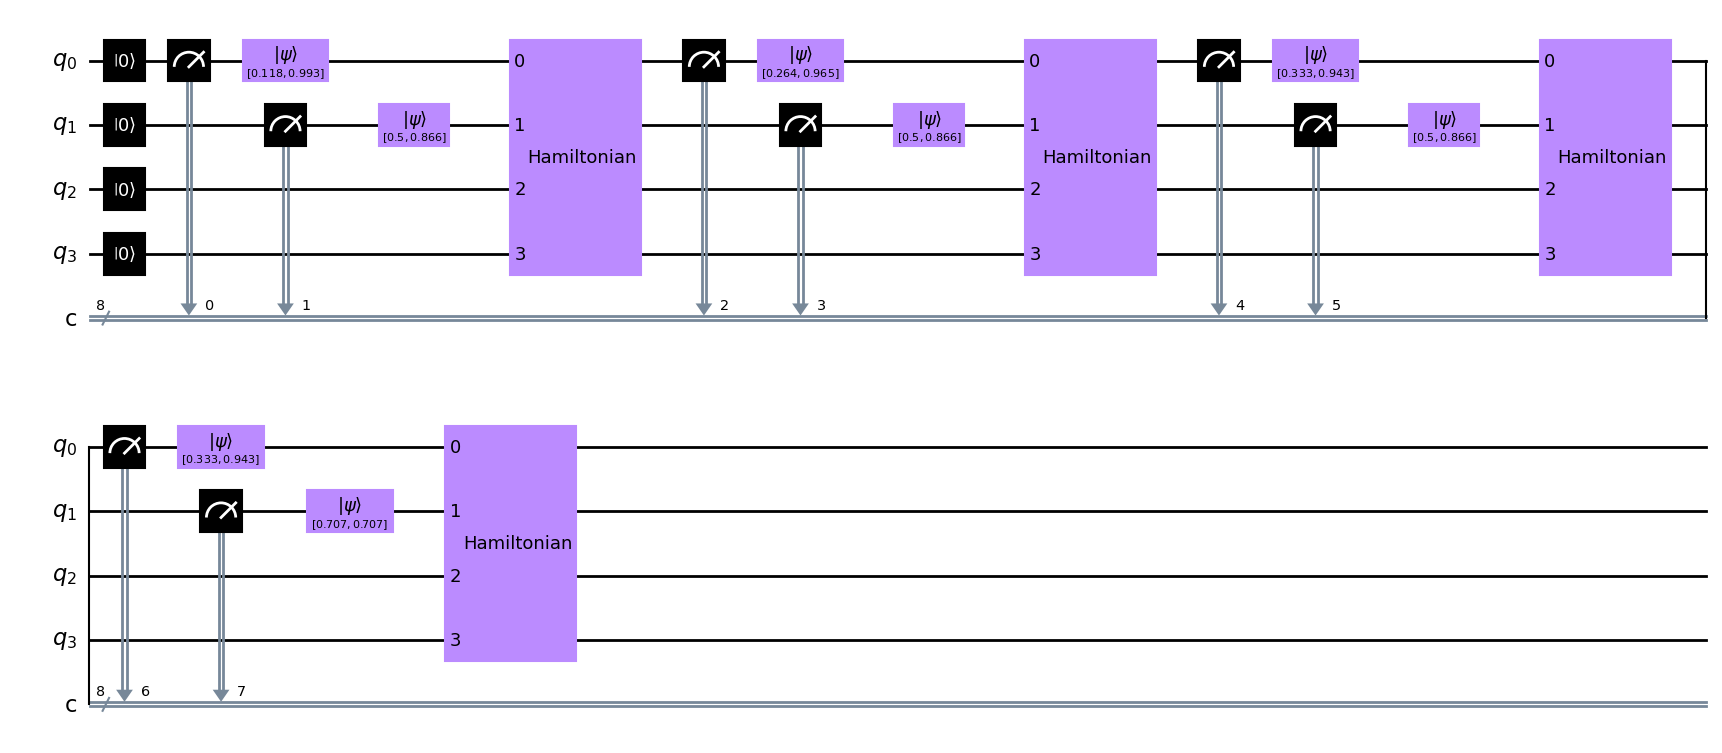

In [5]:

def build_method(circuit, timestep, reservoir):

    note, dur = timestep

    circuit.measure(range(2))
    circuit.initialize([np.sqrt(note), np.sqrt(1-note)], 0)
    circuit.initialize([np.sqrt(dur), np.sqrt(1-dur)], 1)
    
    circuit.append(reservoir, circuit.qubits)

qres1 = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      reservoir = UT)
])

qres1.run(timeseries[:4], transpile=True)

qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      reservoir = UT)
])
# tikzplotlib.save("data/circuit_clifford.tex")
qres1.circuit.draw('mpl')


## Running

In [6]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS,
    transpile=True
)


Simulating:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


In [7]:
# qres.circuit.draw('mpl')

WARMUP = 0.1
warmup_idx = int(len(states) * WARMUP)
xstates = states[:-1][warmup_idx:]
target = np.array(timeseries[1:][warmup_idx:])

## Training

In [8]:


results = utilities.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of Ridge(alpha=0.0, max_iter=100000000): -0.03729523754318316
Score of Ridge(alpha=5.2631578947368425, max_iter=100000000): -0.0674474350812747
Score of Ridge(alpha=10.526315789473685, max_iter=100000000): -0.06749556222454486
Score of Ridge(alpha=15.789473684210527, max_iter=100000000): -0.06751161887952337
Score of Ridge(alpha=21.05263157894737, max_iter=100000000): -0.0675196498886459
Score of Ridge(alpha=26.315789473684212, max_iter=100000000): -0.06752446935292009
Score of Ridge(alpha=31.578947368421055, max_iter=100000000): -0.06752768268709369
Score of Ridge(alpha=36.8421052631579, max_iter=100000000): -0.06752997810118107
Score of Ridge(alpha=42.10526315789474, max_iter=100000000): -0.06753169975768311
Score of Ridge(alpha=47.36842105263158, max_iter=100000000): -0.06753303888071084
Score of Ridge(alpha=52.631578947368425, max_iter=100000000): -0.06753411021495864
Score of Ridge(alpha=57.89473684210527, max_iter=100000000): -0.06753498678484987
Score of Ridge(alpha=63.157

## Predicting

In [9]:
predict_from = timeseries[-20:]
num_preds = 40


pred_states, preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from,
)


Predicting: 100%|██████████| 1620/1620 [04:10<00:00,  6.46it/s]


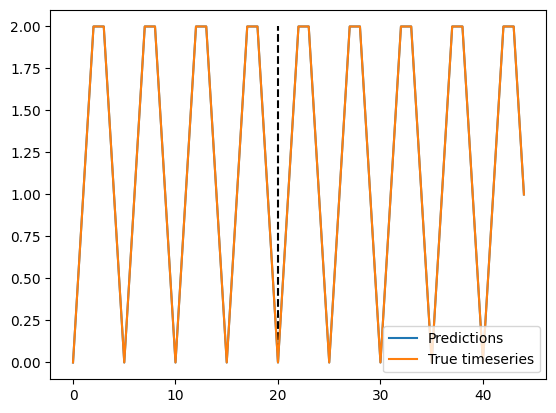

In [ ]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.plot(pred_plot[:minlen], label="Predictions")
plt.vlines(len(predict_from), ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.plot(true_plot[:minlen], label="True timeseries")
plt.legend()

In [19]:
from qreservoirpy import music
# print(preds)


arr = preds.copy()
# print(arr)
arr[:, 0] *= maxval
arr[:, 0] += minval

arr = list(arr)
arr = [(int(a), b) for a,b in arr]
print(arr)


# C=60 A=69

# notes = [music_encoding[elem] for elem in [0, 1, 2, 2, 1]*4]

music.gen_audio(arr, filename="test.wav", BPM=81)

[(63, 0.2828965228919951), (63, 0.22909540767840886), (59, 0.2689937297580527), (63, 0.2872121449835827), (60, 0.250172774057861), (61, 0.28263856626556194), (60, 0.25663645558314085), (61, 0.29173149430416334), (59, 0.24329291620029148), (61, 0.27920730543642236), (61, 0.27184409347431426), (62, 0.3333444170605775), (61, 0.27023575768018393), (60, 0.25645220469102137), (62, 0.32664881009512836), (62, 0.3072382622950851), (61, 0.3007897499441836), (61, 0.28803363563627427), (60, 0.26618239937752364), (61, 0.2972067704839234), (62, 0.2866117177591745), (61, 0.2998208478228652), (61, 0.278212399016168), (61, 0.2986481915852246), (59, 0.2324854412595765), (61, 0.3077996561837608), (62, 0.27818856174214357), (59, 0.2530187768369707), (62, 0.30571663438473573), (61, 0.2659027993893055), (59, 0.2422069678464327), (61, 0.2570634670399863), (61, 0.26288554786754315), (61, 0.25562637998850724), (61, 0.28813117864461235), (61, 0.30293130830314263), (62, 0.27720665747135653), (61, 0.2866182188339